<a href="https://colab.research.google.com/github/ydeng-MLM/PINN_SIREN/blob/main/PINN_quick_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This jupyter notebook implements a PINN (Physics Informed Neural Network) based on SIREN architecture to solve a simple 2D Helmholtz equation in E&M domain:

$$
(-∇^2-ϵω^2)E_z = -iωJ_z
$$

## Source
The inhomogenous PDE will be driven by the current density $J_z = 1$, which can be considered as a point source within the simulation domain.

## Boundary Condition
The simulation domain will have open boundary conditions.

## Overview
Instead of diving right into solving a 2D E&M problem using SIREN, this notebook will start from toy 1D E&M problem, and slowly evolve into a 2D E&M problem after verifying source and boundary conditions. A conventional PINN approach is also tested with DeepXDE.

If you are interested in solving 2D E&M with a point source using SIREN, please proceed to 2D problem section.




# Import & Environment Setup

## Default

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

In [3]:
!pip install SciencePlots

In [4]:
import scienceplots
plt.style.use(['science', 'notebook'])

## DeepXDE

In [5]:
!pip install deepxde

In [6]:
import os
os.environ["DDE_BACKEND"] = "pytorch"

In [7]:
import deepxde as dde
dde.config.set_default_float("float64")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


# SIREN

SIREN definition section


The SIREN implementation directly comes from the colab exmaples from the authors
at [SIREN](https://github.com/vsitzmann/siren)

The bibtex of the work:

```
@inproceedings{sitzmann2019siren,
    author = {Sitzmann, Vi\ncent
              and Martel, Julien N.P.
              and Bergman, Alexander W.
              and Lindell, David B.
              and Wetzstein, Gordon},
    title = {Implicit Neural Representations
              with Periodic Activation Functions},
    booktitle = {arXiv},
    year={2020}
}
```









In [8]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        # Commented out so SIREN model is trained through torch on CUDA directly
        #coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output

In [9]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

# 1D propgating wave

Note in this example there is no source.

The excitation to the system will be done through left boundary of the 1D domain with a $+x$ propagating wave $e^{ikx}$.

source: None

left boundary: plane wave excitation

right boundary: open boundary


Solver/PINN constants/parameters setup

In [10]:
omega = 1
epsilon = 1
k0 = omega * np.sqrt(epsilon)
wave_len = 2 * np.pi / k0
length = wave_len * 5
R = np.pi / 4
n_wave = 20
h_elem = wave_len / n_wave
nx = int(length / h_elem)

Domain & Geometry setup

In [11]:
# Simulation domain setup
x_domain = torch.linspace(-length / 2, length / 2, steps=nx).reshape(-1, 1).requires_grad_(True)

# Boundary
x_left = torch.tensor([[-length / 2]], requires_grad=True)
x_right = torch.tensor([[length / 2]], requires_grad=True)

Solver/PINN setup

In [12]:
model = Siren(
    in_features=1,
    hidden_features=100,
    hidden_layers=3,
    out_features=2,
    outermost_linear=True,
    first_omega_0=omega,
    hidden_omega_0=omega,
)

Model training/Simulation convergence

In [13]:
# PDE residual
def pde_residual(x):
    y = model(x)
    real, imag = y[:, 0:1], y[:, 1:2]

    res_real = -laplace(real, x) - k0**2 * real
    res_imag = -laplace(imag, x) - k0**2 * imag

    return res_real, res_imag


# Boundary Conditions
# Incoming palne wave at left (Dirichlet)
u0 = 1
real_bc_left = u0 * np.cos(k0 * (-length / 2))
imag_bc_left = u0 * np.sin(k0 * (-length / 2))

def boundary_loss():
    y_left = model(x_left)
    y_right = model(x_right)

    real_left, imag_left = y_left[:, 0:1], y_left[:, 1:2]
    real_right, imag_right = y_right[:, 0:1], y_right[:, 1:2]

    d_real_dx = gradient(real_right, x_right)
    d_imag_dx = gradient(imag_right, x_right)

    # Left Dirichlet
    loss_left = (real_left - real_bc_left) ** 2 + (imag_left - imag_bc_left) ** 2

    # Right open boundary
    loss_right_real = (d_real_dx + k0 * imag_right) ** 2
    loss_right_imag = (d_imag_dx - k0 * real_right) ** 2

    return loss_left + loss_right_real + loss_right_imag


# Total Loss
def total_loss(x):
    res_real, res_imag = pde_residual(x)
    loss_pde = (res_real**2).mean() + (res_imag**2).mean()
    loss_bc = boundary_loss()
    return loss_pde + loss_bc


# Training/Simulation
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.8)


for epoch in range(10000):
    optimizer.zero_grad()
    loss = total_loss(x_domain)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4e}")

Epoch 0, Loss: 9.1997e+00
Epoch 500, Loss: 1.5691e-03
Epoch 1000, Loss: 2.6783e-04
Epoch 1500, Loss: 5.0986e-05
Epoch 2000, Loss: 7.2626e-06
Epoch 2500, Loss: 1.4254e-03
Epoch 3000, Loss: 3.1595e-06
Epoch 3500, Loss: 4.9444e-07
Epoch 4000, Loss: 3.6091e-06
Epoch 4500, Loss: 1.9870e-07
Epoch 5000, Loss: 1.7072e-07
Epoch 5500, Loss: 3.2657e-08
Epoch 6000, Loss: 1.9057e-07
Epoch 6500, Loss: 1.2724e-08
Epoch 7000, Loss: 2.2253e-06
Epoch 7500, Loss: 6.0583e-09
Epoch 8000, Loss: 1.7630e-05
Epoch 8500, Loss: 3.1280e-09
Epoch 9000, Loss: 1.2704e-08
Epoch 9500, Loss: 2.1014e-09


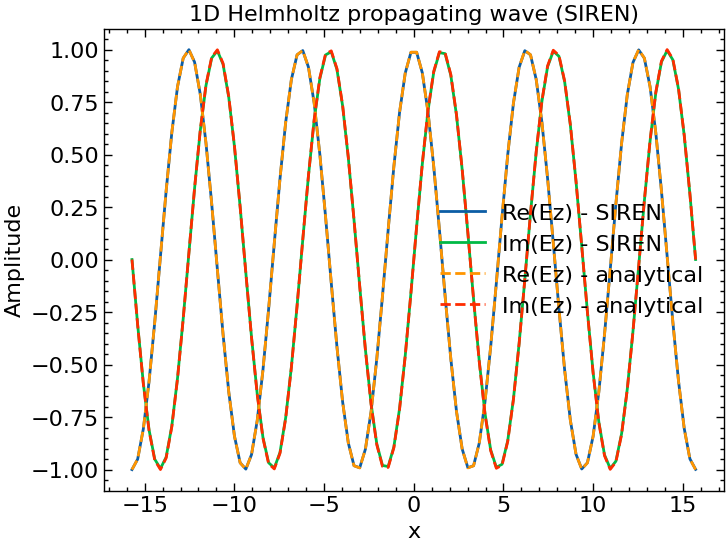

In [14]:
model.eval()
with torch.no_grad():
    y_pred = model(x_domain)
    real = y_pred[:, 0].cpu().numpy()
    imag = y_pred[:, 1].cpu().numpy()
    amp = np.sqrt(real**2 + imag**2)

plt.plot(x_domain.cpu().detach().numpy(), real, label='Re(Ez) - SIREN')
plt.plot(x_domain.cpu().detach().numpy(), imag, label='Im(Ez) - SIREN')
plt.plot(x_domain.cpu().detach().numpy(), np.cos(x_domain.cpu().detach().numpy()), label='Re(Ez) - analytical', linestyle='--')
plt.plot(x_domain.cpu().detach().numpy(), np.sin(x_domain.cpu().detach().numpy()), label='Im(Ez) - analytical', linestyle='--')
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.title("1D Helmholtz propagating wave (SIREN)")
plt.legend()
plt.show()

# 1D point source

Now adding in the 1D point source to validate the point source.

The excitation to the system now will be solely driven by the point source, as described in:

$$
(-∇^2-ϵω^2)E_z = -iωJ_z
$$

source: $J_z = 1$, point source at $x=0$ where a sharpe Gaussian source is used to approximate the point source.

all boundary: open boundary

Note in this case, $Re(E_z)$ still can be written into a homogenous PDE becuase the RHS of PDE is purely imaginary. Therefore, $Re(E_z)$ needs to be accurately solved through the coupling with $Im(E_z)$ at the boundary.

Solver/PINN constants/parameters setup

In [15]:
# It is not necessary to redefine this parameters if simualtion setup is not
# changed. Including setup here for increased mesh, as well as for clarity
omega = 1
epsilon = 1
k0 = omega * np.sqrt(epsilon)
wave_len = 2 * np.pi / k0
length = wave_len * 5
R = np.pi / 4
n_wave = 40
h_elem = wave_len / n_wave
nx = int(length / h_elem)

Domain & Geometry setup

In [16]:
# Simulation domain setup
x_domain = torch.linspace(-length / 2, length / 2, steps=nx).reshape(-1, 1).requires_grad_(True)

# Boundary
x_left = torch.tensor([[-length / 2]], requires_grad=True)
x_right = torch.tensor([[length / 2]], requires_grad=True)

Solver/PINN setup

In [17]:
model = Siren(
    in_features=1,
    hidden_features=50,
    hidden_layers=3,
    out_features=2,
    outermost_linear=True,
    first_omega_0=omega,
    hidden_omega_0=omega,
)

Model training/Simulation convergence

In [18]:
# PDE Residual
def pde_residual(x):
    y = model(x)
    real, imag = y[:, 0:1], y[:, 1:2]

    sigma = wave_len / 80
    delta = (1.0 / (torch.sqrt(torch.tensor(2.0 * torch.pi)) * sigma)) * torch.exp(-x[:, 0:1]**2 / (2 * sigma**2))

    res_real = -laplace(real, x) - k0**2 * real
    res_imag = -laplace(imag, x) - k0**2 * imag + omega * delta

    return res_real, res_imag


# Boundary Conditions
def boundary_loss():
    y_left = model(x_left)
    y_right = model(x_right)

    real_left, imag_left = y_left[:, 0:1], y_left[:, 1:2]
    real_right, imag_right = y_right[:, 0:1], y_right[:, 1:2]

    d_real_dx_left = gradient(real_left, x_left)
    d_imag_dx_left = gradient(imag_left, x_left)

    d_real_dx_right = gradient(real_right, x_right)
    d_imag_dx_right = gradient(imag_right, x_right)

    loss_left_real = (d_real_dx_left - k0 * imag_left) ** 2
    loss_left_imag = (d_imag_dx_left + k0 * real_left) ** 2

    loss_right_real = (d_real_dx_right + k0 * imag_right) ** 2
    loss_right_imag = (d_imag_dx_right - k0 * real_right) ** 2

    return loss_left_real + loss_left_imag + loss_right_real + loss_right_imag


# Training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

for epoch in range(10000):
    optimizer.zero_grad()
    loss = total_loss(x_domain)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4e}")

Epoch 0, Loss: 7.7111e+00
Epoch 500, Loss: 6.1405e-03
Epoch 1000, Loss: 8.6336e-04
Epoch 1500, Loss: 1.9643e-04
Epoch 2000, Loss: 7.3879e-05
Epoch 2500, Loss: 4.9838e-05
Epoch 3000, Loss: 3.4327e-05
Epoch 3500, Loss: 2.4645e-05
Epoch 4000, Loss: 1.8437e-05
Epoch 4500, Loss: 1.5910e-05
Epoch 5000, Loss: 1.3529e-05
Epoch 5500, Loss: 9.7793e-04
Epoch 6000, Loss: 9.7427e-06
Epoch 6500, Loss: 8.9282e-06
Epoch 7000, Loss: 8.1114e-06
Epoch 7500, Loss: 9.5945e-06
Epoch 8000, Loss: 6.5873e-06
Epoch 8500, Loss: 6.2388e-06
Epoch 9000, Loss: 5.8525e-06
Epoch 9500, Loss: 5.4313e-06


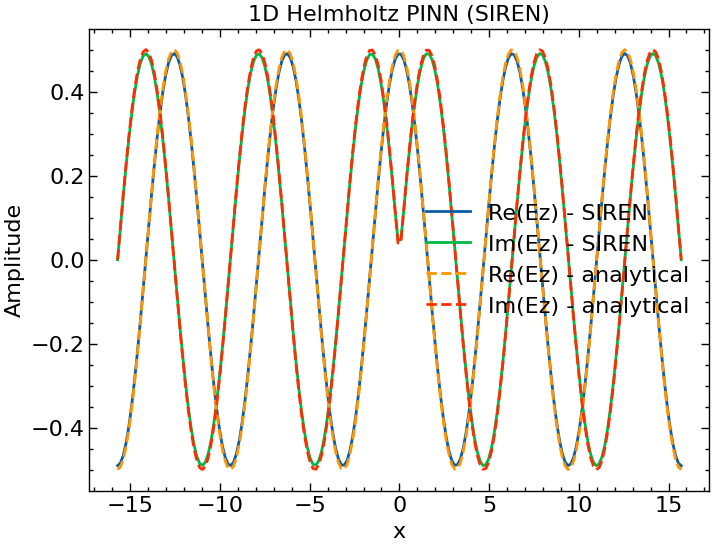

In [19]:
model.eval()
with torch.no_grad():
    y_pred = model(x_domain)
    real = y_pred[:, 0].cpu().numpy()
    imag = y_pred[:, 1].cpu().numpy()
    amp = np.sqrt(real**2 + imag**2)

plt.plot(x_domain.cpu().detach().numpy(), real, label='Re(Ez) - SIREN')
plt.plot(x_domain.cpu().detach().numpy(), imag, label='Im(Ez) - SIREN')
plt.plot(x_domain.cpu().detach().numpy(), (omega / (2 * k0)) * np.cos(np.abs(x_domain.cpu().detach().numpy())), label='Re(Ez) - analytical', linestyle='--')
plt.plot(x_domain.cpu().detach().numpy(), (omega / (2 * k0)) * np.sin(np.abs(x_domain.cpu().detach().numpy())), label='Im(Ez) - analytical', linestyle='--')
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.title("1D Helmholtz PINN (SIREN)")
plt.legend()
plt.show()

# 2D point source

Now with 1D verifications, we can simply expand the PDE to a 2D problem:

$$
(-∇^2-ϵω^2)E_z = -iωJ_z
$$

source: $J_z = 1$, point source at $x =[0, 0]$ where a sharpe Gaussian source is used to approximate the point source.

all boundary: open boundary

Note in this case, $Re(E_z)$ still can be written into a homogenous PDE becuase the RHS of PDE is purely imaginary. Therefore, $Re(E_z)$ needs to be accurately solved through the coupling with $Im(E_z)$ at the boundary.

Solver/PINN constants/parameters setup

In [20]:
omega = 1
epsilon = 1
k0 = omega * np.sqrt(epsilon)
wave_len = 2 * np.pi / k0
length = wave_len * 5
R = np.pi / 4
n_wave = 40
h_elem = wave_len / n_wave
nx = int(length / h_elem)

Domain & Geometry setup

In [21]:
# Simulation domain setup
x = torch.linspace(-length / 2, length / 2, nx)
y = torch.linspace(-length / 2, length / 2, nx)
X, Y = torch.meshgrid(x, y, indexing='ij')
xy = torch.cat((X.reshape(-1, 1), Y.reshape(-1, 1)), dim=1).requires_grad_(True)

# Boundary
x_left = torch.tensor([[-length / 2]], requires_grad=True)
x_right = torch.tensor([[length / 2]], requires_grad=True)

Solver/PINN setup

In [22]:
model = Siren(
    in_features=2,
    hidden_features=300,
    hidden_layers=3,
    out_features=2,
    outermost_linear=True,
    first_omega_0=omega,
    hidden_omega_0=omega,
)

Model training/Simulation convergence

In [23]:
# PDE Residual
def pde_residual(x):
    u = model(x)
    real, imag = u[:, 0:1], u[:, 1:2]

    sigma = wave_len / 40
    r2 = x[:, 0:1]**2 + x[:, 1:2]**2  # squared distance from origin
    delta = (1.0 / (2 * np.pi * sigma**2)) * torch.exp(-r2 / (2 * sigma**2))

    res_real = -laplace(real, x) - k0**2 * real
    res_imag = -laplace(imag, x) - k0**2 * imag + omega * delta
    return res_real, res_imag

# Boundary Conditions
def get_boundary_points(xy, tol=1e-5):
    x, y = xy[:, 0:1], xy[:, 1:2]
    on_left = torch.isclose(x, torch.full_like(x, -length / 2), atol=tol)
    on_right = torch.isclose(x, torch.full_like(x, length / 2), atol=tol)
    on_bottom = torch.isclose(y, torch.full_like(y, -length / 2), atol=tol)
    on_top = torch.isclose(y, torch.full_like(y, length / 2), atol=tol)
    return on_left | on_right | on_bottom | on_top

boundary_mask = get_boundary_points(xy)
xy_boundary = xy[boundary_mask.squeeze()]
xy_boundary.requires_grad_(True)

def boundary_loss():
    total_loss = 0

    def edge_bc(xy_edge, normal):
        u = model(xy_edge)
        real, imag = u[:, 0:1], u[:, 1:2]
        grad_real = torch.autograd.grad(real, xy_edge, grad_outputs=torch.ones_like(real), create_graph=True)[0]
        grad_imag = torch.autograd.grad(imag, xy_edge, grad_outputs=torch.ones_like(imag), create_graph=True)[0]

        du_dn_real = grad_real[:, 0:1] * normal[0] + grad_real[:, 1:2] * normal[1]
        du_dn_imag = grad_imag[:, 0:1] * normal[0] + grad_imag[:, 1:2] * normal[1]

        loss_real = (du_dn_real + k0 * imag) ** 2
        loss_imag = (du_dn_imag - k0 * real) ** 2
        return loss_real.mean() + loss_imag.mean()

    # Define boundary masks
    x, y = xy[:, 0:1], xy[:, 1:2]
    tol = 1e-3
    left_mask   = torch.isclose(x, torch.tensor(-length / 2), atol=tol)
    right_mask  = torch.isclose(x, torch.tensor(length / 2), atol=tol)
    bottom_mask = torch.isclose(y, torch.tensor(-length / 2), atol=tol)
    top_mask    = torch.isclose(y, torch.tensor(length / 2), atol=tol)

    xy_left   = xy[left_mask.squeeze()].detach().clone().requires_grad_(True)
    xy_right  = xy[right_mask.squeeze()].detach().clone().requires_grad_(True)
    xy_bottom = xy[bottom_mask.squeeze()].detach().clone().requires_grad_(True)
    xy_top    = xy[top_mask.squeeze()].detach().clone().requires_grad_(True)

    # Normals for each edge
    total_loss += edge_bc(xy_left,   normal=torch.tensor([-1.0,  0.0], dtype=torch.get_default_dtype()))
    total_loss += edge_bc(xy_right,  normal=torch.tensor([ 1.0,  0.0], dtype=torch.get_default_dtype()))
    total_loss += edge_bc(xy_bottom, normal=torch.tensor([ 0.0, -1.0], dtype=torch.get_default_dtype()))
    total_loss += edge_bc(xy_top,    normal=torch.tensor([ 0.0,  1.0], dtype=torch.get_default_dtype()))

    return total_loss

# Training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.8)

for epoch in range(5000):
    optimizer.zero_grad()
    loss = total_loss(xy)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4e}")

Epoch 0, Loss: 1.2319e+01
Epoch 500, Loss: 2.5333e-03
Epoch 1000, Loss: 3.6767e-02
Epoch 1500, Loss: 1.1410e-03
Epoch 2000, Loss: 7.9263e-04
Epoch 2500, Loss: 4.2041e-04
Epoch 3000, Loss: 5.2147e-04
Epoch 3500, Loss: 1.6333e-04
Epoch 4000, Loss: 4.8192e-04
Epoch 4500, Loss: 8.1329e-05


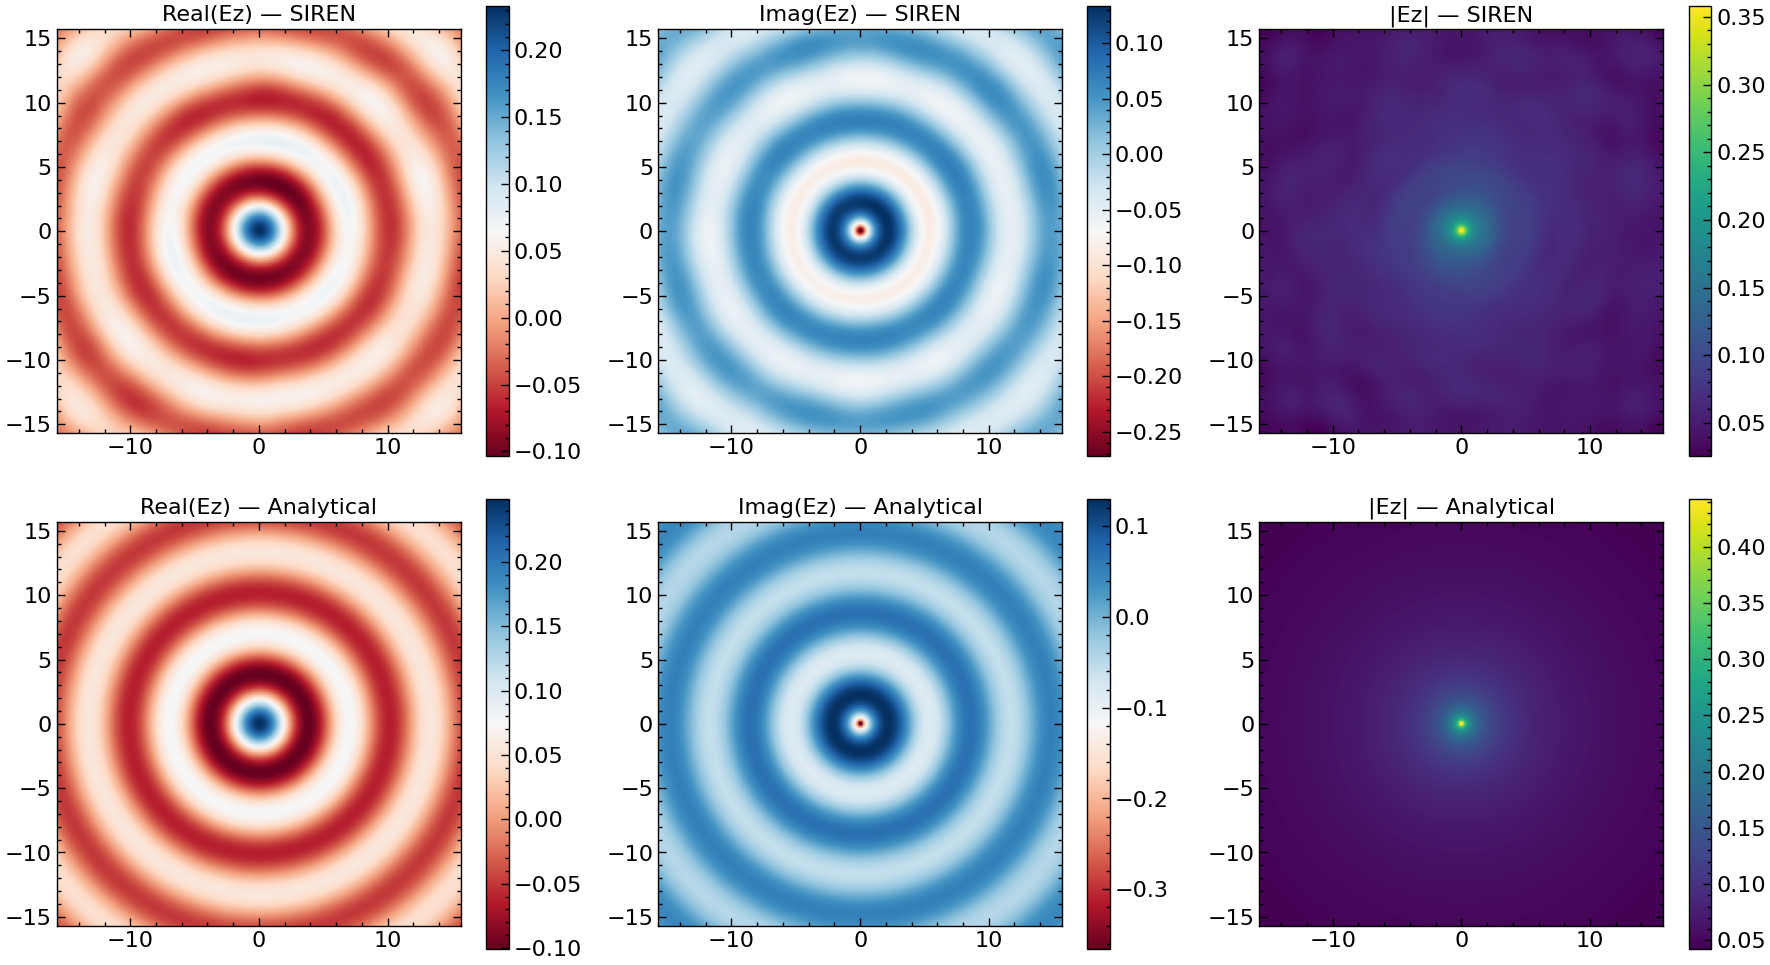

In [25]:
from scipy.special import hankel1

model.eval()
with torch.no_grad():
    u_pred = model(xy)
    real = u_pred[:, 0].reshape(nx, nx).cpu().numpy()
    imag = u_pred[:, 1].reshape(nx, nx).cpu().numpy()
    amp = np.sqrt(real**2 + imag**2)

# Source parameters
I0 = 1j
x0, y0 = 0, 0

# Define grid
rho = np.sqrt((X.cpu().numpy())**2 + (Y.cpu().numpy())**2)

# Analytical solution (Green's function)
Ez = (-1j * omega * I0 / 4) * hankel1(0, k0 * rho)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Numerical Real(Ez)
im1 = axes[0, 0].imshow(real, extent=[-length/2, length/2, -length/2, length/2], cmap='RdBu')
axes[0, 0].set_title('Real(Ez) — SIREN')
plt.colorbar(im1, ax=axes[0, 0])

# Numerical Imag(Ez)
im2 = axes[0, 1].imshow(imag, extent=[-length/2, length/2, -length/2, length/2], cmap='RdBu')
axes[0, 1].set_title('Imag(Ez) — SIREN')
plt.colorbar(im2, ax=axes[0, 1])

# Numerical Magnitude
im3 = axes[0, 2].imshow(amp, extent=[-length/2, length/2, -length/2, length/2], cmap='viridis')
axes[0, 2].set_title('|Ez| — SIREN')
plt.colorbar(im3, ax=axes[0, 2])

# Analytical Real(Ez)
im4 = axes[1, 0].imshow(np.real(Ez), extent=[-length/2, length/2, -length/2, length/2], cmap='RdBu')
axes[1, 0].set_title('Real(Ez) — Analytical')
plt.colorbar(im4, ax=axes[1, 0])

# Analytical Imag(Ez)
im5 = axes[1, 1].imshow(np.imag(Ez), extent=[-length/2, length/2, -length/2, length/2], cmap='RdBu')
axes[1, 1].set_title('Imag(Ez) — Analytical')
plt.colorbar(im5, ax=axes[1, 1])

# Analytical Magnitude
im6 = axes[1, 2].imshow(np.abs(Ez), extent=[-length/2, length/2, -length/2, length/2], cmap='viridis')
axes[1, 2].set_title('|Ez| — Analytical')
plt.colorbar(im6, ax=axes[1, 2])

plt.tight_layout()
plt.show()

# 2D point source - high permitivity circle in the middle

The 2D PDE stays the same in this case, except epsilon has spatial depdence in this case:

$$
(-∇^2-ϵω^2)E_z = -iωJ_z
$$

source: $J_z = 1$, point source at $x =[-L/4, L/4]$ where a sharpe Gaussian source is used to approximate the point source.

all boundary: open boundary

Note in this case, $Re(E_z)$ still can be written into a homogenous PDE becuase the RHS of PDE is purely imaginary. Therefore, $Re(E_z)$ needs to be accurately solved through the coupling with $Im(E_z)$ at the boundary.

Solver/PINN constants/parameters setup

In [26]:
omega = 1
epsilon = 1
k0 = omega * np.sqrt(epsilon)
wave_len = 2 * np.pi / k0
length = wave_len * 5
R = np.pi / 4
n_wave = 40
h_elem = wave_len / n_wave
nx = int(length / h_elem)

def permittivity(x, radius=wave_len):
  r2 = x[:, 0:1]**2 + x[:, 1:2]**2
  eps = torch.ones_like(r2)
  eps[r2 < radius**2] = 2.0  # Inside the circle
  return eps

Domain & Geometry setup

In [27]:
# Simulation domain setup
x = torch.linspace(-length / 2, length / 2, nx)
y = torch.linspace(-length / 2, length / 2, nx)
X, Y = torch.meshgrid(x, y, indexing='ij')
xy = torch.cat((X.reshape(-1, 1), Y.reshape(-1, 1)), dim=1).requires_grad_(True)

# Boundary
x_left = torch.tensor([[-length / 2]], requires_grad=True)
x_right = torch.tensor([[length / 2]], requires_grad=True)

Solver/PINN setup

In [28]:
model = Siren(
    in_features=2,
    hidden_features=300,
    hidden_layers=3,
    out_features=2,
    outermost_linear=True,
    first_omega_0=omega,
    hidden_omega_0=omega,
)

Model training/Simulation convergence

In [29]:
# PDE Residual
def pde_residual(x):
    u = model(x)
    real, imag = u[:, 0:1], u[:, 1:2]

    eps = permittivity(x)
    k = omega * torch.sqrt(eps)

    sigma = wave_len / 40
    r2 = (x[:, 0:1] - length/4)**2 + (x[:, 1:2] + length/4)**2  # squared distance from origin
    delta = (1.0 / (2 * np.pi * sigma**2)) * torch.exp(-r2 / (2 * sigma**2))

    res_real = -laplace(real, x) - k**2 * real
    res_imag = -laplace(imag, x) - k**2 * imag + omega * delta
    return res_real, res_imag

# Boundary Conditions
def get_boundary_points(xy, tol=1e-5):
    x, y = xy[:, 0:1], xy[:, 1:2]
    on_left = torch.isclose(x, torch.full_like(x, -length / 2), atol=tol)
    on_right = torch.isclose(x, torch.full_like(x, length / 2), atol=tol)
    on_bottom = torch.isclose(y, torch.full_like(y, -length / 2), atol=tol)
    on_top = torch.isclose(y, torch.full_like(y, length / 2), atol=tol)
    return on_left | on_right | on_bottom | on_top

boundary_mask = get_boundary_points(xy)
xy_boundary = xy[boundary_mask.squeeze()]
xy_boundary.requires_grad_(True)

def boundary_loss():
    total_loss = 0

    def edge_bc(xy_edge, normal):
        u = model(xy_edge)
        real, imag = u[:, 0:1], u[:, 1:2]
        grad_real = torch.autograd.grad(real, xy_edge, grad_outputs=torch.ones_like(real), create_graph=True)[0]
        grad_imag = torch.autograd.grad(imag, xy_edge, grad_outputs=torch.ones_like(imag), create_graph=True)[0]

        du_dn_real = grad_real[:, 0:1] * normal[0] + grad_real[:, 1:2] * normal[1]
        du_dn_imag = grad_imag[:, 0:1] * normal[0] + grad_imag[:, 1:2] * normal[1]

        loss_real = (du_dn_real + k0 * imag) ** 2
        loss_imag = (du_dn_imag - k0 * real) ** 2
        return loss_real.mean() + loss_imag.mean()

    # Define boundary masks
    x, y = xy[:, 0:1], xy[:, 1:2]
    tol = 1e-3
    left_mask   = torch.isclose(x, torch.tensor(-length / 2), atol=tol)
    right_mask  = torch.isclose(x, torch.tensor(length / 2), atol=tol)
    bottom_mask = torch.isclose(y, torch.tensor(-length / 2), atol=tol)
    top_mask    = torch.isclose(y, torch.tensor(length / 2), atol=tol)

    xy_left   = xy[left_mask.squeeze()].detach().clone().requires_grad_(True)
    xy_right  = xy[right_mask.squeeze()].detach().clone().requires_grad_(True)
    xy_bottom = xy[bottom_mask.squeeze()].detach().clone().requires_grad_(True)
    xy_top    = xy[top_mask.squeeze()].detach().clone().requires_grad_(True)

    # Normals for each edge
    total_loss += edge_bc(xy_left,   normal=torch.tensor([-1.0,  0.0], dtype=torch.get_default_dtype()))
    total_loss += edge_bc(xy_right,  normal=torch.tensor([ 1.0,  0.0], dtype=torch.get_default_dtype()))
    total_loss += edge_bc(xy_bottom, normal=torch.tensor([ 0.0, -1.0], dtype=torch.get_default_dtype()))
    total_loss += edge_bc(xy_top,    normal=torch.tensor([ 0.0,  1.0], dtype=torch.get_default_dtype()))

    return total_loss

# Training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.8)

for epoch in range(5000):
    optimizer.zero_grad()
    loss = total_loss(xy)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4e}")

Epoch 0, Loss: 8.5363e+00
Epoch 500, Loss: 3.1516e-03
Epoch 1000, Loss: 2.3748e-03
Epoch 1500, Loss: 2.0457e-03
Epoch 2000, Loss: 1.7269e-03
Epoch 2500, Loss: 1.3617e-03
Epoch 3000, Loss: 9.6969e-04
Epoch 3500, Loss: 6.4748e-04
Epoch 4000, Loss: 5.6197e-04
Epoch 4500, Loss: 2.8284e-04


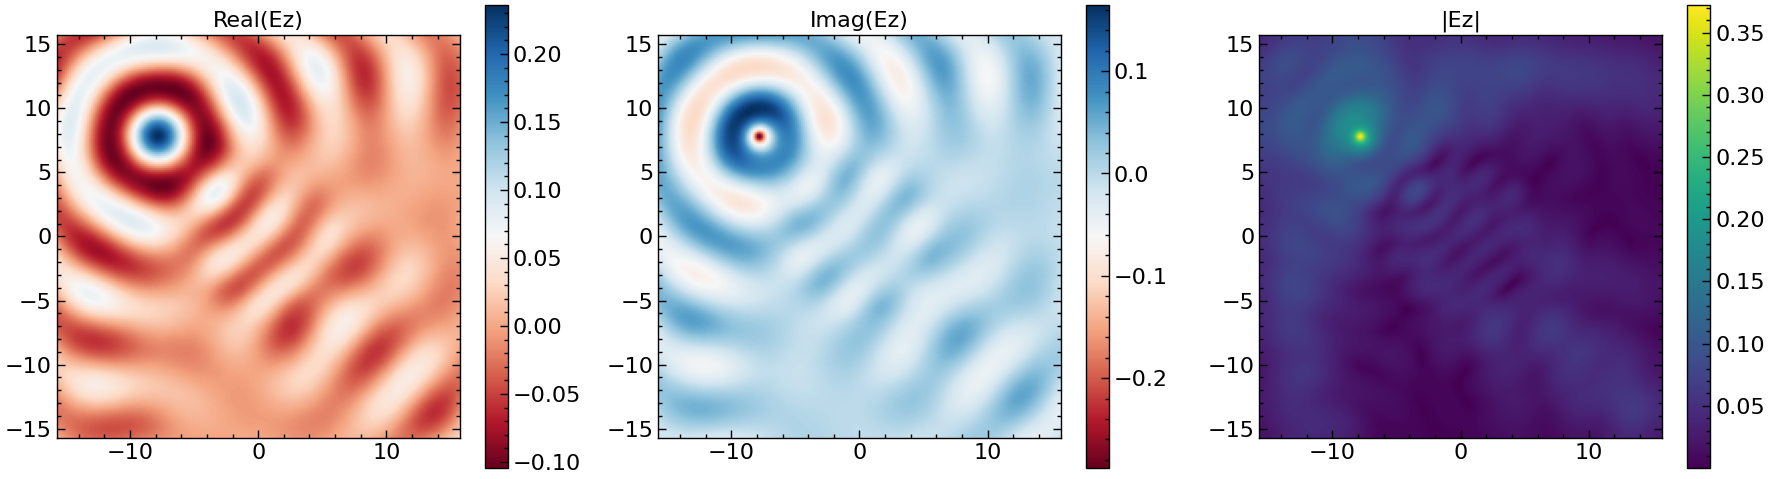

In [30]:
model.eval()
with torch.no_grad():
    u_pred = model(xy)
    real = u_pred[:, 0].reshape(nx, nx).cpu().numpy()
    imag = u_pred[:, 1].reshape(nx, nx).cpu().numpy()
    amp = np.sqrt(real**2 + imag**2)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Numerical Real(Ez)
im1 = axes[0].imshow(real, extent=[-length/2, length/2, -length/2, length/2], origin='lower', cmap='RdBu')
axes[0].set_title('Real(Ez)')
plt.colorbar(im1, ax=axes[0])

# Numerical Imag(Ez)
im2 = axes[1].imshow(imag, extent=[-length/2, length/2, -length/2, length/2], origin='lower', cmap='RdBu')
axes[1].set_title('Imag(Ez)')
plt.colorbar(im2, ax=axes[1])

# Numerical Magnitude
im3 = axes[2].imshow(amp, extent=[-length/2, length/2, -length/2, length/2], origin='lower', cmap='viridis')
axes[2].set_title('|Ez|')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

# DeepXDE Reference

The main motivation to include DeepXDE here is to check how much slower FNN will be comparing to SIREN on periodic problems.

In harder problem FNN does not even converge within reasonable iterations.

## 1D propagating wave - DeepXDE

Compiling model...
'compile' took 0.000464 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.60e-01, 4.70e-02, 6.25e-02, 6.55e-01, 1.40e-01, 3.44e-02]    [3.73e-01, 1.64e-01, 6.25e-02, 6.55e-01, 1.40e-01, 3.44e-02]    []  
1000      [2.57e-04, 2.36e-05, 3.78e-08, 5.95e-08, 6.05e-09, 5.73e-08]    [4.30e-03, 4.07e-04, 3.78e-08, 5.95e-08, 6.05e-09, 5.73e-08]    []  
2000      [1.13e-04, 6.43e-06, 2.34e-09, 9.35e-09, 1.34e-08, 1.80e-11]    [1.92e-03, 1.11e-04, 2.34e-09, 9.35e-09, 1.34e-08, 1.80e-11]    []  
3000      [7.10e-05, 1.29e-05, 1.12e-09, 1.15e-08, 8.35e-09, 2.81e-13]    [1.22e-03, 2.24e-04, 1.12e-09, 1.15e-08, 8.35e-09, 2.81e-13]    []  
4000      [3.36e-05, 1.62e-05, 2.12e-10, 1.77e-09, 5.83e-10, 2.31e-14]    [5.77e-04, 2.71e-04, 2.12e-10, 1.77e-09, 5.83e-10, 2.31e-14]    []  
5000      [1.27e-05, 1.26e-05, 9.23e-13, 7.47e-09, 6.63e-09, 8.97e-09]

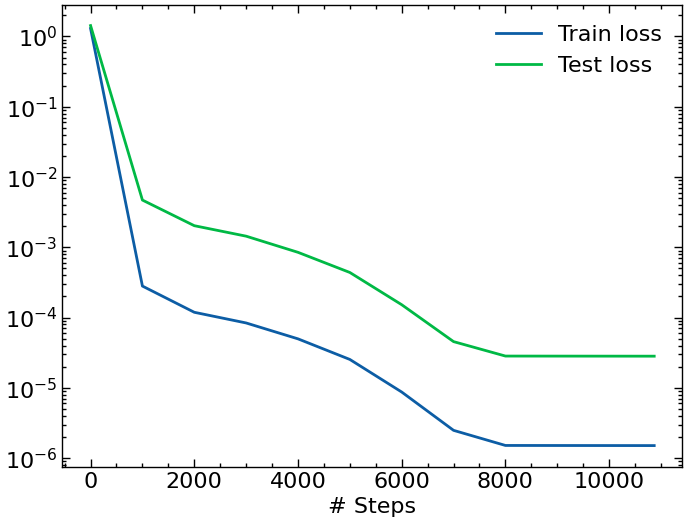

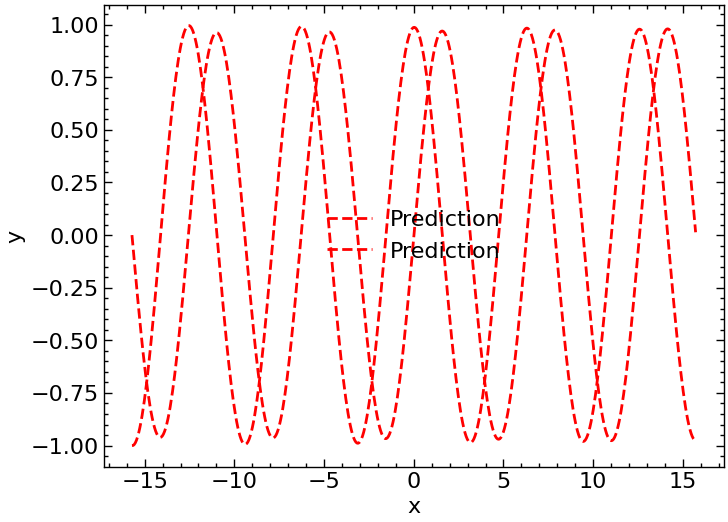

In [31]:
# PINN parameters
weights = 1
iterations = 10000
learning_rate = 1e-3
num_dense_layers = 3
num_dense_nodes = 100
activation = "sin"

# PDE parameters
omega = 1
epsilon = 1
k0 = omega * np.sqrt(epsilon)
wave_len = 2 * np.pi / k0
length = wave_len * 5
R = np.pi / 4
n_wave = 20
h_elem = wave_len / n_wave
nx = int(length / h_elem)


# Computational domain
geom = dde.geometry.Interval(-length / 2, length / 2)

# Definition of the homogeneous PDE
def pde(x, y):
    y0, y1 = y[:, 0:1], y[:, 1:2]

    y0_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    y1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    return [-y0_xx - k0**2 * y0, -y1_xx - k0**2 * y1]

# Boundary set up
def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], length / 2)

def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], -length / 2)

# Right boundary conditions - open boundary, outgoing wave
bc_real_right = dde.OperatorBC(
    geom,
    lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=0) + k0 * y[:, 1:2],
    boundary_right
)

bc_imag_right = dde.OperatorBC(
    geom,
    lambda x, y, _: dde.grad.jacobian(y, x, i=1, j=0) - k0 * y[:, 0:1],
    boundary_right
)

# Left boundary conditions - driving force, incoming wave
u0=1
bc_real_left = dde.DirichletBC(
    geom, lambda x: u0 * np.cos(k0 * (-length/2)), boundary_left, component=0
)
bc_imag_left = dde.DirichletBC(
    geom, lambda x: u0 * np.sin(k0 * (-length/2)), boundary_left, component=1
)

# Combine boundary conditions
bcs = [
    bc_real_right, bc_imag_right,
    bc_real_left, bc_imag_left,
]

loss_weights = [1, 1, weights, weights, weights, weights]

data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=nx,
    num_boundary=16 * nx, # Setting the boundary points high since real part of Ez soley determined by coupling at the boundary
    num_test=5 * nx,
)
net = dde.maps.FNN(
    [1] + [num_dense_nodes] * num_dense_layers + [2], activation, "Glorot uniform"
)
model = dde.Model(data, net)

dde.optimizers.set_LBFGS_options(
    maxiter=iterations,
    gtol=1e-20,
    ftol=1e-20,
    maxcor=100,
    maxfun=150000,
)
model.compile("L-BFGS", loss_weights=loss_weights)  # Adam will not work so well
losshistory, train_state = model.train()

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## 1D point source - DeepXDE

In [ ]:
# PINN parameters
weights = 1
iterations = 10000
learning_rate = 1e-3
num_dense_layers = 3
num_dense_nodes = 100
activation = "sin"

# PDE parameters
omega = 1
epsilon = 1
k0 = omega * np.sqrt(epsilon)
wave_len = 2 * np.pi / k0
length = wave_len * 5
R = np.pi / 4
n_wave = 20
h_elem = wave_len / n_wave
nx = int(length / h_elem)


# Computational domain
geom = dde.geometry.Interval(-length / 2, length / 2)

# Definition of the inhomogeneous PDE
def pde(x, y):
    y0, y1 = y[:, 0:1], y[:, 1:2]

    y0_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    y1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    sigma = wave_len / 10
    delta = (1.0 / (torch.sqrt(torch.tensor(2.0 * torch.pi)) * sigma)) * torch.exp(-x[:, 0:1]**2 / (2 * sigma**2))

    return [
        -y0_xx - k0**2 * y0,
        -y1_xx - k0**2 * y1 + omega * delta,
    ]

# Boundary set up
def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], length / 2)

def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], -length / 2)

# Right boundary conditions - open boundary, outgoing wave
bc_real_right = dde.OperatorBC(
    geom,
    lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=0) + k0 * y[:, 1:2],
    boundary_right
)

bc_imag_right = dde.OperatorBC(
    geom,
    lambda x, y, _: dde.grad.jacobian(y, x, i=1, j=0) - k0 * y[:, 0:1],
    boundary_right
)

# Left boundary conditions - open boundary, outgoing wave
bc_real_left = dde.OperatorBC(
    geom,
    lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=0) - k0 * y[:, 1:2],
    boundary_left
)

bc_imag_left = dde.OperatorBC(
    geom,
    lambda x, y, _: dde.grad.jacobian(y, x, i=1, j=0) + k0 * y[:, 0:1],
    boundary_left
)

# Update boundary conditions list
bcs = [
    bc_real_right, bc_imag_right,
    bc_real_left, bc_imag_left,
]

loss_weights = [1, 1, weights, weights, weights, weights]

data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=nx,
    num_boundary=16 * nx,
    num_test=5 * nx,
)
net = dde.maps.FNN(
    [1] + [num_dense_nodes] * num_dense_layers + [2], activation, "Glorot uniform"
)
model = dde.Model(data, net)

dde.optimizers.set_LBFGS_options(
    maxiter=iterations,
    gtol=1e-20,
    ftol=1e-20,
    maxcor=100,
    maxfun=150000,
)
model.compile("L-BFGS", loss_weights=loss_weights)
losshistory, train_state = model.train()

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## 2D point source - DeepXDE

In [ ]:
# PINN parameters
weights = 1
iterations = 4000
learning_rate = 1e-3
num_dense_layers = 2
num_dense_nodes = 50
activation = "tanh"

# PDE parameters
omega = 1
epsilon = 1
k0 = omega * np.sqrt(epsilon)
wave_len = 2 * np.pi / k0
length = wave_len * 5
R = np.pi / 4
n_wave = 20
h_elem = wave_len / n_wave
nx = int(length / h_elem)


# Computational domain
geom = dde.geometry.Rectangle([-length / 2, -length / 2], [length / 2, length / 2])

# Definition of the inhomogeneous PDE
def pde(x, y):
    y0, y1 = y[:, 0:1], y[:, 1:2]

    y0_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    y0_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)

    y1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    y1_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)

    # Gaussian source centered at (0, 0)
    sigma = 0.1
    r2 = x[:, 0:1]**2 + x[:, 1:2]**2
    delta = (1.0 / (2 * torch.pi * sigma**2)) * torch.exp(-r2 / (2 * sigma**2))

    return [
        - (y0_xx + y0_yy) - k0**2 * y0,
        - (y1_xx + y1_yy) - k0**2 * y1 + omega * delta
    ]


# Boundary set up
def on_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], -length / 2)

def on_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], length / 2)

def on_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], -length / 2)

def on_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], length / 2)


# LEFT boundary (normal = [-1, 0])
bc_real_left = dde.OperatorBC(
    geom,
    lambda x, y, _: -dde.grad.jacobian(y, x, i=0, j=0) - k0 * y[:, 1:2],
    on_left,
)
bc_imag_left = dde.OperatorBC(
    geom,
    lambda x, y, _: -dde.grad.jacobian(y, x, i=1, j=0) + k0 * y[:, 0:1],
    on_left,
)

# RIGHT boundary (normal = [+1, 0])
bc_real_right = dde.OperatorBC(
    geom,
    lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=0) - k0 * y[:, 1:2],
    on_right,
)
bc_imag_right = dde.OperatorBC(
    geom,
    lambda x, y, _: dde.grad.jacobian(y, x, i=1, j=0) + k0 * y[:, 0:1],
    on_right,
)

# BOTTOM boundary (normal = [0, -1])
bc_real_bottom = dde.OperatorBC(
    geom,
    lambda x, y, _: -dde.grad.jacobian(y, x, i=0, j=1) - k0 * y[:, 1:2],
    on_bottom,
)
bc_imag_bottom = dde.OperatorBC(
    geom,
    lambda x, y, _: -dde.grad.jacobian(y, x, i=1, j=1) + k0 * y[:, 0:1],
    on_bottom,
)

# TOP boundary (normal = [0, +1])
bc_real_top = dde.OperatorBC(
    geom,
    lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1) - k0 * y[:, 1:2],
    on_top,
)
bc_imag_top = dde.OperatorBC(
    geom,
    lambda x, y, _: dde.grad.jacobian(y, x, i=1, j=1) + k0 * y[:, 0:1],
    on_top,
)

bcs = [
    bc_real_left, bc_imag_left,
    bc_real_right, bc_imag_right,
    bc_real_bottom, bc_imag_bottom,
    bc_real_top, bc_imag_top,
]


loss_weights = [1, 1, weights, weights, weights, weights, weights, weights, weights, weights]

data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=5*nx**2,
    num_boundary=32 * nx,
    num_test=5*nx**2,
)
net = dde.maps.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [2], activation, "Glorot normal"
)
model = dde.Model(data, net)

dde.optimizers.set_LBFGS_options(
    maxiter=iterations,
    gtol=1e-20,
    ftol=1e-20,
    maxcor=100,
    maxfun=150000,
)
model.compile("L-BFGS", loss_weights=loss_weights)
losshistory, train_state = model.train()

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

With similar model size, FNN cannot converge to a reasonable E&M solution for 2D point source problem

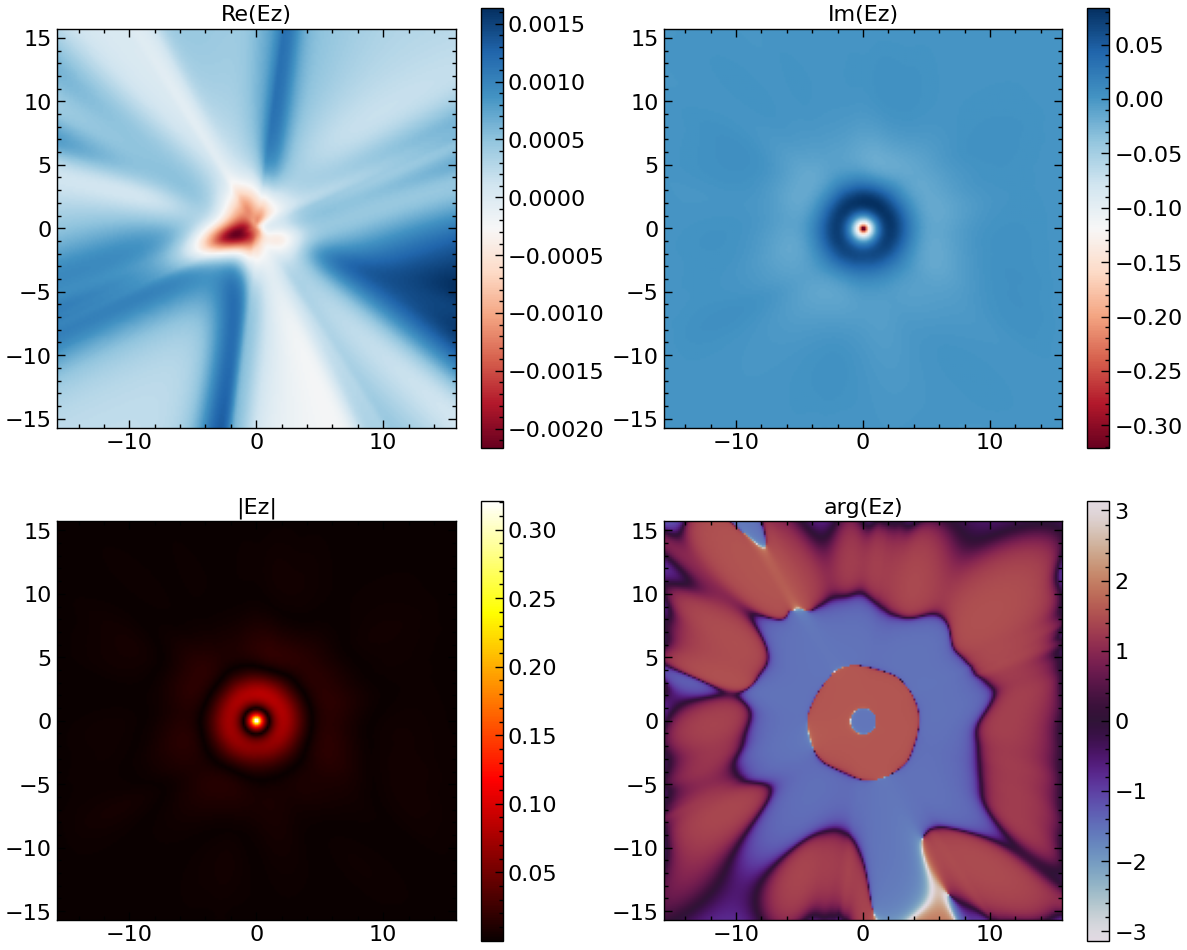

In [34]:
# Generate mesh grid points for prediction
n = 200
x = np.linspace(-length / 2, length / 2, n)
y = np.linspace(-length / 2, length / 2, n)
X, Y = np.meshgrid(x, y)
XY = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

# Predict Ez = u + i*v
Ez_pred = model.predict(XY)
u = Ez_pred[:, 0].reshape(n, n)
v = Ez_pred[:, 1].reshape(n, n)
abs_Ez = np.sqrt(u**2 + v**2)
phase = np.arctan2(v, u)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Real part
im0 = axs[0, 0].imshow(u, extent=[-length / 2, length / 2, -length / 2, length / 2], origin="lower", cmap="RdBu")
axs[0, 0].set_title("Re(Ez)")
fig.colorbar(im0, ax=axs[0, 0])

# Imag part
im1 = axs[0, 1].imshow(v, extent=[-length / 2, length / 2, -length / 2, length / 2], origin="lower", cmap="RdBu")
axs[0, 1].set_title("Im(Ez)")
fig.colorbar(im1, ax=axs[0, 1])

# Magnitude
im2 = axs[1, 0].imshow(abs_Ez, extent=[-length / 2, length / 2, -length / 2, length / 2], origin="lower", cmap="hot")
axs[1, 0].set_title("|Ez|")
fig.colorbar(im2, ax=axs[1, 0])

# Phase
im3 = axs[1, 1].imshow(phase, extent=[-length / 2, length / 2, -length / 2, length / 2], origin="lower", cmap="twilight")
axs[1, 1].set_title("arg(Ez)")
fig.colorbar(im3, ax=axs[1, 1])

plt.tight_layout()
plt.show()
